Simulation of moving bar with two cell types and delayed feedback
July 28, 2020 created by CKC
based on NF_MB_02 but with a smooth moving bar by using a stimulation with continuous position

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

functions

In [2]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt


        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [3]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [4]:
def K(x,s):
    return (np.exp(-(x/s)**2))/(s*np.sqrt(np.pi))

In [5]:
# Guassian function with mean x0 and standard deviation sigma
def G(x,x0,sigma):
    y = np.exp(-((x-x0)/sigma)**2)
    return(y)

# Main

In [6]:
sigma_h = 1.1 # all 'dimention-L' parameters are narmalize by sigma_h
sigma_c = 0.5*sigma_h
sigma_g = 10.*sigma_c

dx = 0.005*sigma_h
xlen = 5000 #spatial 'step' of simulation
xaxis = np.arange(0, xlen)*dx

dis_h = sigma_h
dis_c = sigma_c
h_loc = np.zeros(xlen)
locx = np.arange(dis_h, xlen*dx-dx, dis_h)/dx
h_loc[np.round(locx).astype(int)] = 1
c_loc = np.zeros(xlen)
locx = np.arange(dis_c, xlen*dx-dx, dis_c)/dx
c_loc[np.round(locx).astype(int)] = 1

sum(h_loc)

24.0

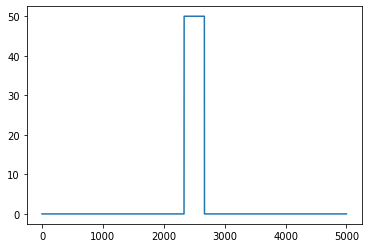

In [7]:
s = np.zeros(xlen)
i0 = xlen/2
hw = (sigma_g/6)
s[round(i0-hw/dx):round(i0+hw/dx)] = 50
plt.plot(s)

In [8]:
klen = min(sigma_h*3, int(xlen*dx/2))
xx = np.arange(-klen,klen,dx)

KC = K(xx,sigma_c)
KH = K(xx,sigma_h)
KG = K(xx,sigma_g)

In [9]:
alpha = 50
beta = 2
k = 500
phi = 1.*sigma_h/sigma_c
g = 20*sigma_c/sigma_h

k*g*phi/alpha/beta

100.0

Smooth motion

In [10]:
dt = 0.001
pos_0 = 2500.*dx
nstep = 1500
vdt =  0.01*sigma_h # moving bar velocity  #pos_0+vdt*400 <= xlen-pos0
speak = np.zeros(nstep)
for i in range(nstep):
    if i < 400:
        pos = pos_0 + vdt*i
    if i > 400 and i <800:
        pos = pos - vdt
    speak[i] = pos

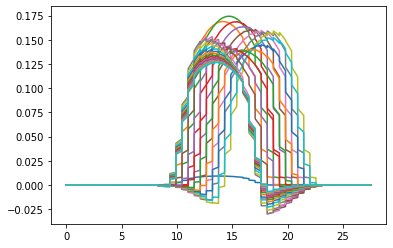

In [11]:
y = np.zeros(xlen) # cone cell output
z = np.zeros(xlen) # horizontal cell output
rz = np.zeros(xlen) 
ry = np.convolve(y,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)

rpeak = np.zeros(nstep)

stm = []
rsp = []
zts = []
tmp = []

for i in range(nstep):
    pos = speak[i]
    
    s = np.zeros(xlen)
    s[int(round((pos-hw)/dx)):int(round((pos+hw)/dx))] = 10
    rs =  np.convolve(s,KC,'same')*dx

    dyj =(-alpha*y+k*(rs-phi*rz))*dt
    dzj =(-beta*z+g*y)*dt
#     y = (y+dyj)
#     z = (z+dzj)
    
    y = (y+dyj)*c_loc
    z = (z+dzj)*h_loc
# 

    
    rz = np.convolve(z,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    ry = np.convolve(y,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)

    output = np.convolve(y,KG,'same')*dx
#     output = y
    
    rpeak[i]= np.argmax(output)
    
    stm.append(rs.copy())
    rsp.append(output.copy())
    zts.append(z.copy())
    
    if i%50 == 0:
        #plt.plot(y[maxpos-50:maxpos+50])
        plt.plot(xaxis, output)
        tmp.append(output)
        #plt.plot(rs/7)

(1667.000000000056, 3333.000000000056)

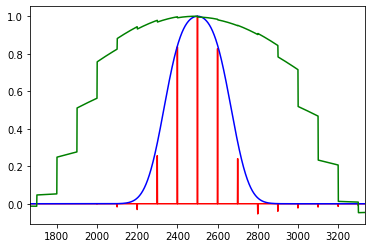

In [12]:
plt.plot(y/np.max(y),'r')
plt.plot(rs/np.max(rs),'b')
plt.plot(output/np.max(output),'g')

#plt.plot(z)
plt.xlim([speak[-1]/dx-int(hw*5/dx), speak[-1]/dx+int(hw*5/dx)])

In [13]:
# activation function
def A(x,theta):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

(2392.0, 2592.0)

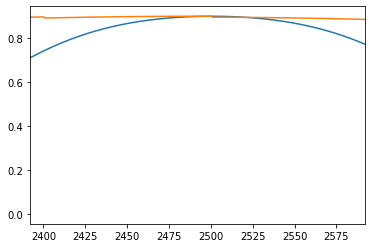

In [14]:
# shown with activatin function
rrs = rs/np.max(rs)
yy = output/np.max(output)
plt.plot(A(rrs,0.1))
plt.plot(A(yy,0.1))
plt.xlim([rpeak[-1]-100,rpeak[-1]+100])

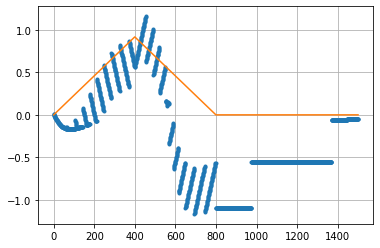

In [15]:
# difference between stimualtion and response peak
plt.plot((rpeak*dx-speak),'.')
n_traj = (speak-pos_0)/max((speak-pos_0))*hw
plt.plot(n_traj)
plt.grid()
#plt.ylim([0,15])
#plt.xlim([350,450])

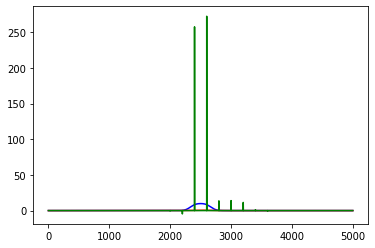

In [16]:
# spatial distribution of cells at final state
plt.plot(rs,'b') # stimualtion
plt.plot(ry,'r')  # cone cell
plt.plot(z,'g')  # horizontal cell

10


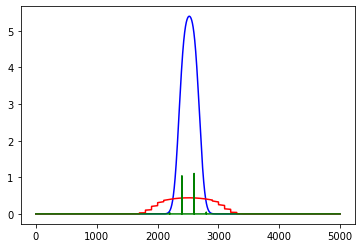

200


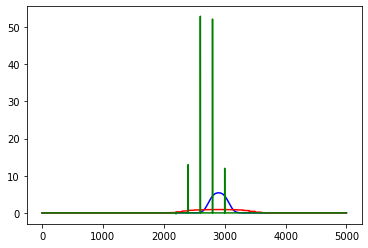

300


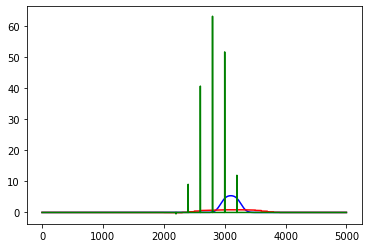

400


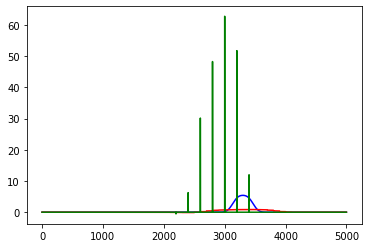

500


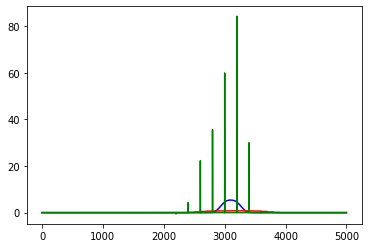

600


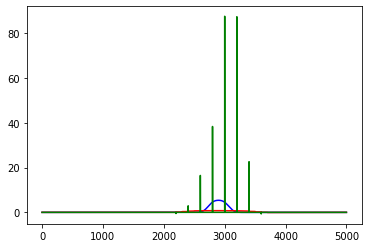

700


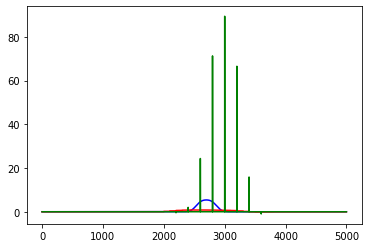

800


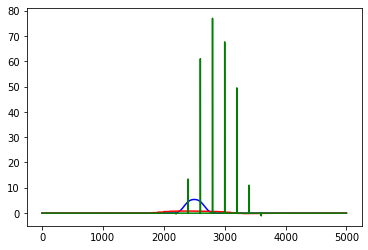

1000


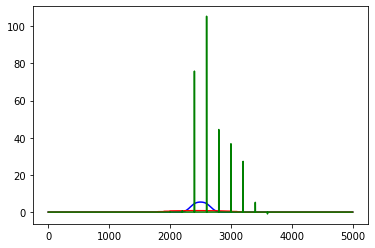

1199


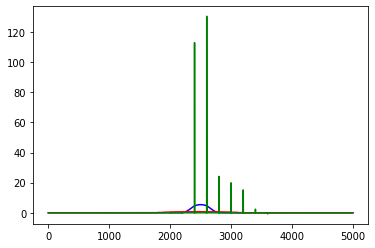

1499


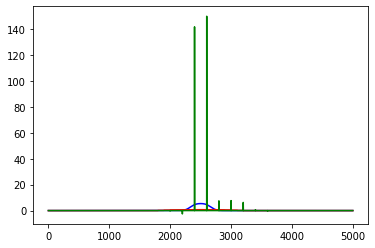

In [17]:
# snapshot at different time
for index in [10, 200, 300, 400, 500, 600, 700, 800, 1000, 1199, 1499]:
    plt.figure()
    print(index)
    plt.plot(stm[index]*sigma_c,'b')
    plt.plot(rsp[index]*sigma_g,'r')
    plt.plot(zts[index]*sigma_c,'g')
    plt.show()


MB  LPOU

In [41]:
#main
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 0.5
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

nstep = 5000
#rescale
speak = LPOU[:nstep]
speak = ((speak - np.mean(speak))/(max(speak)-min(speak))*(hw*24)+xlen/2)*dx

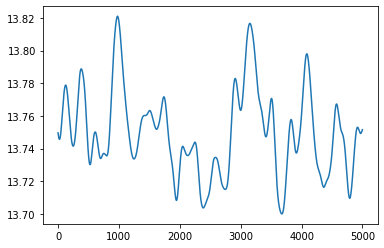

In [42]:
plt.plot(speak)

In [43]:
y = np.zeros(xlen) # cone cell output
z = np.zeros(xlen) # horizontal cell output
rz = np.zeros(xlen) 
ry = np.convolve(y,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)

rpeak = np.zeros(nstep)

stm = []
rsp = []
zts = []
tmp = []

for i in range(nstep):
    pos = speak[i]
    
    s = np.zeros(xlen)
    s[int(round((pos-hw)/dx)):int(round((pos+hw)/dx))] = 10
    rs =  np.convolve(s,KC,'same')*dx

    dyj =(-alpha*y+k*(rs-phi*rz))*dt
    dzj =(-beta*z+g*y)*dt
#     y = (y+dyj)
#     z = (z+dzj)
    
    y = (y+dyj)*c_loc
    z = (z+dzj)*h_loc

    
    rz = np.convolve(z,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    ry = np.convolve(y,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)

    output = np.convolve(y,KG,'same')*dx

    
    rpeak[i]= np.argmax(output)
    
    stm.append(rs.copy())
    rsp.append(output.copy())
    zts.append(z.copy())

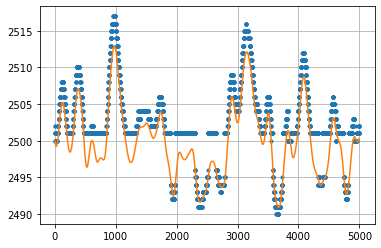

In [44]:
# difference between stimualtion and response peak
plt.plot((rpeak),'.')
plt.plot(speak/dx)
plt.grid()
#plt.ylim([0,15])
#plt.xlim([350,450])

In [45]:
one_RGC = []
index = int(np.mean(rpeak))
index = 2505
for output in rsp:
    one_RGC.append(output[index])
one_RGC = np.array(one_RGC[120:])

In [46]:
window = [-1, 1]
xstate, _ = EqualState(speak[120:], 6)
v = ndimage.gaussian_filter1d(speak.copy(), sigma=1, order=1, mode='wrap') / dt
vstate, _ = EqualState(v[120:], 6)
rstate, _ = EqualState(one_RGC, 6)
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply


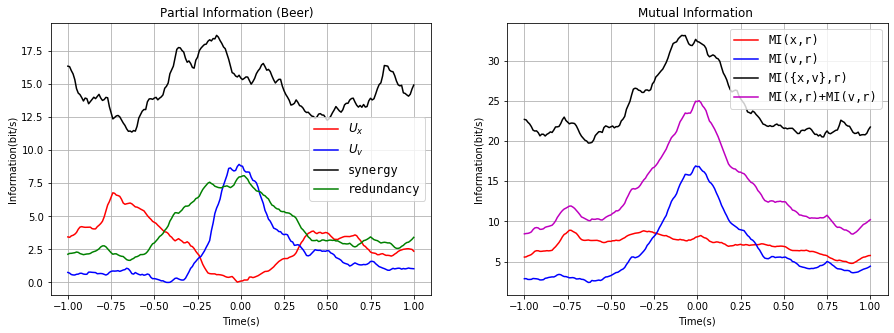

In [47]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)  ')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_title('Mutual Information ')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

In [48]:
window = [-1, 1]
xstate, _ = EqualState(speak, 6)
v = ndimage.gaussian_filter1d(speak.copy(), sigma=1, order=1, mode='wrap') / dt
vstate, _ = EqualState(v, 6)
rstate, _ = EqualState(rpeak, 6)
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anac

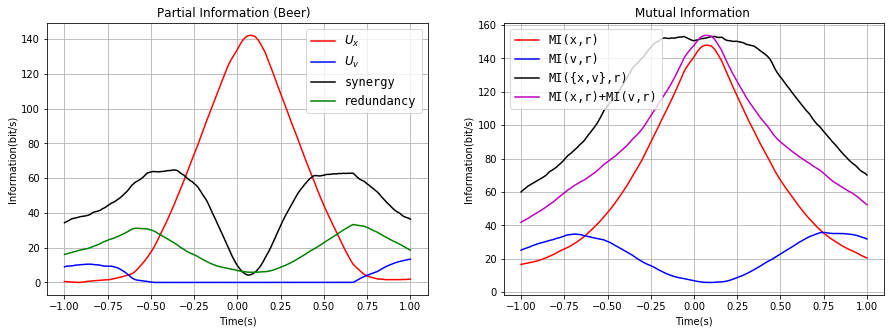

In [49]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)  ')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_title('Mutual Information ')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

WF LPOU

In [27]:
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

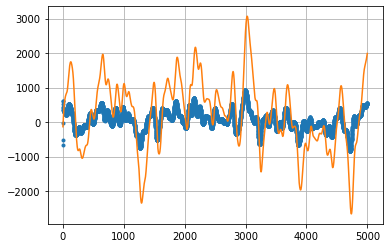

In [28]:
pos_0 = 0
y = np.zeros(xlen) # cone cell output
z = np.zeros(xlen) # horizontal cell output
rz = np.zeros(xlen) # horizontal cell output
ry = np.convolve(y,KH,'same') # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
nstep = 5000

speak = LPOU[0:nstep]
rpeak = np.zeros(nstep)

stm = []
rsp = []
zts = []
tmp = []


for i in range(nstep):
    rs =  np.ones(xlen)*speak[i]

    dyj =(-alpha*y+k*(rs-rz))*dt
    y = (y+dyj)*c_loc
    dzj =(-beta*z+g*y)*dt
    z = (z+dzj)*h_loc
        
    rz = np.convolve(z,KH,'same') # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    ry = np.convolve(y,KH,'same') # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)

    

    rpeak[i]= y[2500]
    
    stm.append(rs.copy())
    rsp.append(y.copy())
    zts.append(z.copy())
    
plt.plot(rpeak,'.')
plt.plot((speak))
plt.grid()

In [29]:
window = [-1, 1]
xstate, _ = EqualState(speak, 6)
v = ndimage.gaussian_filter1d(speak.copy(), sigma=1, order=1, mode='wrap') / dt
vstate, _ = EqualState(v, 6)
rstate, _ = EqualState(rpeak, 6)
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\

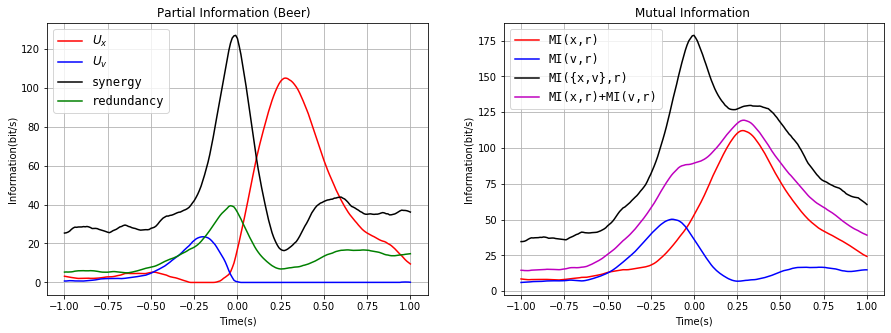

In [30]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)  ')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_title('Mutual Information ')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)